## Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Extended Model

This notebook is for improvements to the logistic regression model in the 'Baseline Model' notebook. We will extend by trying a Random Forest Classfier and a multilayer Neural Net. To develop improved results, we will examine two strategies for dealing with the imbalance in the data (noted in the 'Data Exploration' notebook).

In [1]:
import numpy as np
import modin.pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline

import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
#tensorflow logging may be causing memory leak crashing notebook
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
Xy_crop_df=pd.read_csv('saved/Xy_crop_df.csv',index_col=0)

The classifiers we are trying here are known to work better with scaled data, so we will fit a standard scaler at this point. Since we will also do image augmentation later on, which needs pre-scaled data, we'll fit now and transform the train sets later.

In [4]:
scaler = StandardScaler()
scaler.fit(Xy_crop_df.iloc[:,:3072].values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(Xy_crop_df.iloc[:,:3072].values,
                                                Xy_crop_df.label.values,
                                                stratify=Xy_crop_df.label.values,
                                                random_state=42)

In [6]:
X_train_scaled = scaler.transform(X_train) #scale train set and save as new
X_test = scaler.transform(X_test) #scale test set


Now that we are ready, we will use the following to find the best classifier:
* Random Forest
* Neural Network


Classification Report (test):
              precision    recall  f1-score   support

           0       0.76      0.88      0.81     32727
           1       0.77      0.59      0.67     22280

    accuracy                           0.76     55007
   macro avg       0.76      0.73      0.74     55007
weighted avg       0.76      0.76      0.76     55007

Confusion Matrix:
[[28765  3962]
 [ 9123 13157]]


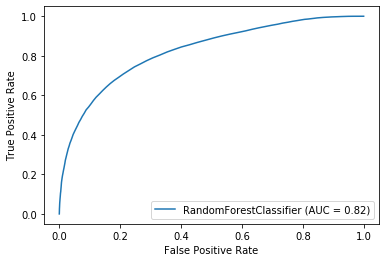

In [9]:
print('Classification Report (test):')
print(classification_report(y_test,model.predict(X_test)))
print('Confusion Matrix:')
print(confusion_matrix(y_test,model.predict(X_test)))
plot_roc_curve(model,X_test,y_test)
plt.show()

In [ ]:
mlp = MLPClassifier(early_stopping=True)
mlp.fit(X_train_scaled, y_train)

In [ ]:
pred=mlp.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(mlp,X_test,y_test)
plt.show()

In [ ]:
pred=model.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(model,X_test,y_test)
plt.show()

In [ ]:
#setup same for neural net

In [ ]:
from sklearn.neural_network import MLPClassifier
clfn = MLPClassifier(solver='adam',
                    hidden_layer_sizes=(100,10,),
                    early_stopping=True)
clfn.fit(X_train_scaled,y_train)


In [ ]:
pred=clfn.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(clfn,X_test,y_test)
plt.show()

We can see that the neural net isn't getting better results. At this point I would like to examine why. The first thing that comes to mind is the imbalance in the dataset. There are 40.5% positive and 59.5% negative samples.


First thing we'll try is the simplest strategy, a random undersampling of the majority class. The overall set is 220000 images so there will still be enough to train the classifier using only 85% of them.

Since we can't know whether any particular random sample will be better than another, we will do several. We are going to hold out a test set so that we can evaluate each trial against the same set. 20% should be enough.

#since we'll be iterating through the differently undersampled training sets, we need to scale the data now rather than later

In [17]:
pos=len(y_train[y_train==1])
neg=len(y_train[y_train==0])
print('n Positive: ',pos)
print('n Negative: ',neg)
print('difference: ',neg-pos)
print('total: ',pos+neg)

n Positive:  66837
n Negative:  98181
difference:  31344


There are $$\binom{31344}{154018}$$ (way too many) different ways to randomly undersample the majority class so that it matches the minority class here, so we have to choose a subset. 

We will take a few subsets, and put them in a pipeline using the best parameters of the classifiers we tuned earlier. Then we'll roll it all into an ensemble classifier that uses majority vote.

#### Random Undersampling Pipeline

* random undersampler
* model (MLP Classifier)
* record precision & recall

In [7]:
n_iter=6 #number of iteriations

rus=RandomUnderSampler()
mlp=MLPClassifier()
rfc=RandomForestClassifier(n_jobs=-1)
pipe_names=[]
rus_names=[]


In [8]:
rus_0=RandomUnderSampler(random_state=0)
rus_1=RandomUnderSampler(random_state=1)
rus_2=RandomUnderSampler(random_state=2)
rus_3=RandomUnderSampler(random_state=3)
rus_4=RandomUnderSampler(random_state=4)
rus_5=RandomUnderSampler(random_state=5)

pipe_0=make_pipeline(rus_0,rfc)
pipe_1=make_pipeline(rus_1,rfc)
pipe_2=make_pipeline(rus_2,rfc)
pipe_3=make_pipeline(rus_3,rfc)
pipe_4=make_pipeline(rus_4,rfc)
pipe_5=make_pipeline(rus_5,rfc)

pipes=[('pipe_0',pipe_0),
       ('pipe_1',pipe_1),
       ('pipe_2',pipe_2),
       ('pipe_3',pipe_3),
       ('pipe_4',pipe_4),
       ('pipe_5',pipe_5)]

In [9]:
from sklearn.ensemble import VotingClassifier

clf=VotingClassifier(estimators=pipes,n_jobs=-1)

In [10]:
clf.fit(X_train_scaled,y_train)

VotingClassifier(estimators=[('pipe_0',
                              Pipeline(memory=None,
                                       steps=[('randomundersampler',
                                               RandomUnderSampler(random_state=0,
                                                                  replacement=False,
                                                                  sampling_strategy='auto')),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(bootstrap=True,
                                                                      ccp_alpha=0.0,
                                                                      class_weight=None,
                                                                      criterion='gini',
                                                                      max_depth=None,
                                                                      m

In [28]:
pred=clf.predict(X_test)
print('Classification Report:')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
#plot_roc_curve(clf,X_test,y_test)
print(clf.score(X_test,y_test))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81     32727
           1       0.72      0.71      0.71     22280

    accuracy                           0.77     55007
   macro avg       0.76      0.76      0.76     55007
weighted avg       0.77      0.77      0.77     55007

Confusion Matrix:
[[26567  6160]
 [ 6536 15744]]
0.7691930117984984


So let's look at the difference in performance, specifically recall and precision:

Random undersampling gave us a slight degradation in performance metrics. Notice the difference is greater for the undersampled class. So perhaps this classifier is sensitive to the size of the dataset. If that's the ccase, we may be able to od better by oversampling the minority set rather than undersampling the majority set. 


A common way to do this with data like this is image augemntation. We will perturb some images in the minority set to create new ones.

### image augmentation with imgaug


In [12]:
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import imgaug as ia


The image transformations expect to see images in the typical shape (3-d arrays of int values 0-255) we need to start from the loaded data and reshape the it before scaling.

Many transformations assume the images are in the normal shape (3-d array) so we're going to reshape the images back to that shape first

In [13]:
#reshape the images and recast as uint8
X_train=X_train.reshape((X_train.shape[0],32,32,3)).astype(np.uint8)

In [14]:
#pull out the positive images.
#Recall from earlier this is the minority class we need to augment
Xy_z=zip(X_train,y_train)

X_p=[]
for X,y in Xy_z:
    if y==1:
        X_p.append(X)
       

We need to be somewhat careful which transformations to apply to the images. We know that the a positive slide is defined as having 1 pixel of cancer cell in it. But without specific domain knowledge about exactly how to identify those cells we need to be careful that any transformations don't degrade that information, either by changing pixel values too much or by removing important pixels.

Given that, we will apply transformations that shift pixel location but not pixel values. Some examples of these are:
* Flipping
* Rotation
* Skew
* Jitter

In [15]:
# Define an augmentation pipeline
aug_pipeline = iaa.Sequential([
       
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Flipud(1.0), # vertically flip
        iaa.Rot90(1,3),  # rotate 90, 180, or 270 degrees        
    ])    
],
random_order=True # apply the augmentations in random order
)

In [16]:
#make a random selection of positive samples
n_aug=len(X_train)-2*len(X_p) #number of samples to augment the class by

X_p=shuffle(X_p)


In [17]:
# Apply augmentation pipeline
X_aug = np.array([aug_pipeline.augment_image(each) for each in X_p[:n_aug]])

In [18]:
X_augl = list(X_aug[:4])

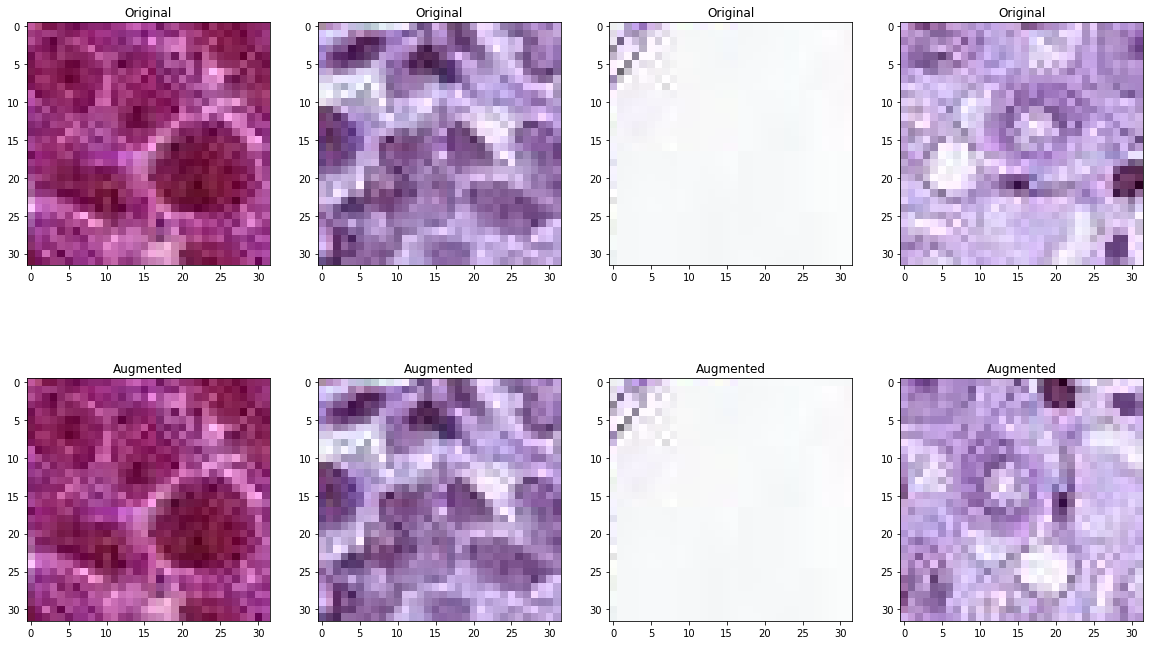

In [19]:
fig,ax = plt.subplots(2,4, figsize=(20,12))
#4 original
for i in range(4):
    ax[0,i].imshow(X_p[i])
    ax[0,i].set_title('Original')

#4 augmented
for i in range(4):
    ax[1,i].imshow(X_aug[i])
    ax[1,i].set_title('Augmented')
plt.show()

In [20]:
#flatten the images
X_train=np.array([each.flatten() for each in X_train])
X_aug=np.array([each.flatten() for each in X_aug])

In [21]:
#add augmented images to the training set
X_train=np.concatenate((X_train,X_aug))

In [22]:
#add labels to y_test
y_aug=np.full((len(X_aug),),1)

y_train=np.concatenate((y_train,y_aug))

In [23]:
#scale the training set
X_train = scaler.transform(X_train) 

In [33]:
mod_aug = RandomForestClassifier(n_jobs=-1)
mod_aug.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Classification Report (test):
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     32727
           1       0.72      0.70      0.71     22280

    accuracy                           0.77     55007
   macro avg       0.76      0.76      0.76     55007
weighted avg       0.77      0.77      0.77     55007

Confusion Matrix:
[[26501  6226]
 [ 6655 15625]]


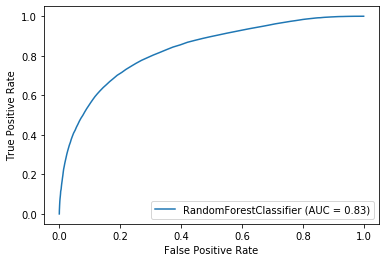

In [34]:
pred=mod_aug.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(mod_aug,X_test,y_test)
plt.show()

#### Summary

By undersampling, we were able to improve performance of the classifiers somewhat, and by oversampling with image augmentation we were able to achieve slightly better imporvements as you see in the table below:


| Model | Class | Precision | Recall | 
| --- | --- | --- | --- |
| Baseline Random Forest | 0 | 0.76 | 0.88 |
|  | 1 | 0.77 | 0.59 | 
| Undersampling Ensemble | 0 | 0.80 | 0.81 |
| | 1 | 0.72 | 0.71 |
| Image Augmentation | 0 | 0.80 | 0.81 |
| | 1 | 0.72 | 0.70 |
| Image Augementation + Hyperparameter Tuning | 0 | | |
|  | 1 | | |


####  We can see from this table that both of the tested methods of balancing the dataset -- random undersampling and random image augmentation -- yield similar improvement.  

In [26]:
from sklearn.model_selection import GridSearchCV

#parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 3000, num = 3)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
criterion = ['entropy']

params={'n_estimators': n_estimators,        
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'criterion': criterion}

In [29]:
rfc=RandomForestClassifier()

rf_rand=GridSearchCV(estimator=rfc, 
                           param_grid=params,                            
                           cv=3,
                           n_jobs=-1)
rf_rand.fit(X_train,y_train)

rf_rand.best_params_

KeyboardInterrupt: 

In [ ]:
mod_rfc = RandomForestClassifier(n_estimators=2450,
                               max_features='sqrt',
                               criterion='entropy',
                               n_jobs=-1)
# Fit on training data
mod_rfc.fit(X_train, y_train)

In [ ]:
pred=mod_rfc.predict(X_test)
print('Classification Report (test):')
print(classification_report(y_test,pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test,pred))
plot_roc_curve(mod_rfc,X_test,y_test)
plt.show()